In [1]:
# -- driver_run_forecast_LV1.py  --
# master python script to do a full LV1 forecast simulation

import sys
import pickle
#import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timezone
import gc
import resource
import subprocess
#import xarray as xr
#import netCDF4 as nc

##############

sys.path.append('../sdpm_py_util')

import atm_functions as atmfuns
import ocn_functions as ocnfuns
import grid_functions as grdfuns
import util_functions as utlfuns 
import plotting_functions as pltfuns
from util_functions import s_coordinate_4
from get_PFM_info import get_PFM_info
from make_LV1_dotin_and_SLURM import make_LV1_dotin_and_SLURM
from run_slurm_LV1 import run_slurm_LV1


PFM=get_PFM_info()

run_type = 'forecast'
# we will use hycom for IC and BC
ocn_mod = PFM['ocn_model']
print('ocean boundary and initial conditions will be from:')
print(ocn_mod)
# we will use nam_nest for the atm forcing
atm_mod = PFM['atm_model']
print('atm forcing will be from:')
print(atm_mod)
# we will use opendap, and netcdf to grab ocn, and atm data
get_method = 'open_dap_nc'
# figure out what the time is local and UTC
start_time = datetime.now()
utc_time = datetime.now(timezone.utc)
year_utc = utc_time.year
month_utc = utc_time.month
day_utc = utc_time.day
hour_utc = utc_time.hour

print("Starting: driver_run_forecast_LV1: Current local Time =", start_time, "UTC = ",utc_time)

if hour_utc < 12:
    hour_utc=12
    day_utc=day_utc-1  # this only works if day_utc \neq 1

yyyymmdd = "%d%02d%02d" % (year_utc, month_utc, day_utc)
    
#yyyymmdd = '20240717'
# the hour in Z of the forecast, hycom has forecasts once per day starting at 1200Z
hhmm='1200'
forecastZdatestr = yyyymmdd+hhmm+'Z'   # this could be used for model output to indicate when model was initialized.

yyyymmdd = '20240804'
print("Preparing forecast starting on ",yyyymmdd)


# get the ROMS grid as a dict
RMG = grdfuns.roms_grid_to_dict(PFM['lv1_grid_file'])


get_PFM_info(): running onswell
ocean boundary and initial conditions will be from:
hycom
atm forcing will be from:
nam_nest
Starting: driver_run_forecast_LV1: Current local Time = 2024-08-08 15:41:24.498284 UTC =  2024-08-08 22:41:24.498307+00:00
Preparing forecast starting on  20240804


/home/mspydell/models/PFM_root/PFM/driver/../sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [2]:
print('before getting OCN, using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')

use_ncks = 1 # flag to get data using ncks. if =0, then a pre saved pickle file is loaded.
use_pckl_sav = 1
if use_ncks == 1:
    if use_pckl_sav == 0: # the original way that breaks when going to OCN_R
        OCN = ocnfuns.get_ocn_data_as_dict(yyyymmdd,run_type,ocn_mod,'ncks_para')
        print('driver_run_forecast_LV1: done with get_ocn_data_as_dict: Current time ',datetime.now() )
        print('after getting OCN with ncks_para, using:')
        print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
        print('kilobytes')
    else:
        print('going to use subprocess, and save a pickle file.')
        fn_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocn_tmp_pckl_file']
        os.chdir('../sdpm_py_util')
        cmd_list = ['python','ocn_functions.py','get_ocn_data_as_dict_pckl',yyyymmdd,run_type,ocn_mod,'ncks_para']
        ret1 = subprocess.run(cmd_list)     
        os.chdir('../driver')
        print('hycom data saved with pickle, correctly?')
        print(ret1)
        print('0=yes,1=no')

        #with open(fn_pckl,'rb') as fp:
        #    OCN = pickle.load(fp)
        #    print('OCN dict now loaded with pickle')
        #    print('after getting OCN from file, using:')
        #    print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
        #    print('kilobytes')

else:
    save_ocn = 0 # if 0, this loads the pickle file. if 1, it saves the pickle file
    import pickle
    # save the OCN dict so that we can restart the python session
    # and not have to worry about opendap timing out
    fnout='/scratch/PFM_Simulations/LV1_Forecast/Forc/ocn_dict_file_2024-07-29T12:00.pkl'
    if save_ocn == 1:
        with open(fnout,'wb') as fp:
            pickle.dump(OCN,fp)
            print('OCN dict saved with pickle')
    else:
        fn_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocn_tmp_pckl_file']
        with open(fn_pckl,'rb') as fp:
            #OCN = pickle.load(fp)
            print('OCN dict loaded with pickle')
            print('after getting OCN from file, using:')
            print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
            print('kilobytes')



before getting OCN, using:
265704
kilobytes
going to use subprocess, and save a pickle file.


/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


get_PFM_info(): running onswell
in the parallel ncks switch
Time to get full file using parallel ncks = 42.74 sec
Return code = 0 (0=success, 1=skipped ncks)
Hycom OCN dict saved with pickle
hycom data saved with pickle, correctly?
CompletedProcess(args=['python', 'ocn_functions.py', 'get_ocn_data_as_dict_pckl', '20240804', 'forecast', 'hycom', 'ncks_para'], returncode=0)
0=yes,1=no


In [3]:
## plot OCN
plot_ocn = 1
if plot_ocn ==1:
    pltfuns.plot_ocn_fields_from_dict_pckl(fn_pckl)


get_PFM_info(): running onswell
/scratch/PFM_Simulations/LV1_Forecast/Forc/hycom_tmp_pckl_file.pkl
OCN dict loaded with pickle


In [4]:

print('before gc.collect and getting OCN_R, using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')
gc.collect()
print('after gc.collect and before OCN_R, using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')
# put the ocn data on the roms grid
print('starting: ocnfuns.hycom_to_roms_latlon(OCN,RMG)')
sv_ocnR_pkl_file=1
if sv_ocnR_pkl_file==0:
    print('returning OCN_R')
    OCN_R  = ocnfuns.hycom_to_roms_latlon(OCN,RMG)
else:
    print('going to save OCN_R to temp pickle files.')
    os.chdir('../sdpm_py_util')
    cmd_list = ['python','ocn_functions.py','hycom_to_roms_latlon_pckl',fn_pckl]
    print(cmd_list)
    ret2 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('OCN_R data saved to pickle files, correctly?')
    print(ret2)
    print('0=yes,1=no')

print('driver_run_forecast_LV1: done with hycom_to_roms_latlon')
# add OCN + OCN_R plotting function here !!!
print('using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')



before gc.collect and getting OCN_R, using:
794392
kilobytes
after gc.collect and before OCN_R, using:
794392
kilobytes
starting: ocnfuns.hycom_to_roms_latlon(OCN,RMG)
going to save OCN_R to temp pickle files.
['python', 'ocn_functions.py', 'hycom_to_roms_latlon_pckl', '/scratch/PFM_Simulations/LV1_Forecast/Forc/hycom_tmp_pckl_file.pkl']


/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


get_PFM_info(): running onswell
/scratch/PFM_Simulations/LV1_Forecast/Forc/hycom_tmp_pckl_file.pkl
OCN dict loaded with pickle
before interp to roms grid, using:
794392
kilobytes
doing:
zeta
doing:
temp
doing:
salt
doing:
u
doing:
v
before rotating urm, using:
4478164
kilobytes
before rotating vrm, using:
6365048
kilobytes
after v rotation. before ubar
about to save OCN_R to multiple pickle files...
after gc.collect and before pickling OCN_R, using:
6365048
kilobytes
saved pickle file: /scratch/PFM_Simulations/LV1_Forecast/Forc/tmp_zeta.pkl
saved pickle file: /scratch/PFM_Simulations/LV1_Forecast/Forc/tmp_salt.pkl
saved pickle file: /scratch/PFM_Simulations/LV1_Forecast/Forc/tmp_temp.pkl
saved pickle file: /scratch/PFM_Simulations/LV1_Forecast/Forc/tmp_ubar.pkl
saved pickle file: /scratch/PFM_Simulations/LV1_Forecast/Forc/tmp_vbar.pkl
saved pickle file: /scratch/PFM_Simulations/LV1_Forecast/Forc/tmp_lat_rho.pkl
saved pickle file: /scratch/PFM_Simulations/LV1_Forecast/Forc/tmp_lon_rho.p

In [2]:
## plot OCN_R
plot_ocnr = 1
if plot_ocnr == 1:
    pltfuns.plot_ocn_R_fields_pckl()


get_PFM_info(): running onswell
get_PFM_info(): running onswell


In [3]:
print('using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')
# %%
# get the OCN_IC dictionary

fr_ocnR_pkl_file=1
if fr_ocnR_pkl_file==0:
    OCN_IC = ocnfuns.ocn_r_2_ICdict(OCN_R,RMG,PFM)
else:
    print('going to save OCN_IC to a pickle file to:')
    ocnIC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnIC_tmp_pckl_file']
    print(ocnIC_pckl) 
    os.chdir('../sdpm_py_util')
    cmd_list = ['python','ocn_functions.py','ocn_r_2_ICdict_pckl',ocnIC_pckl]
    ret3 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('OCN IC data saved with pickle, correctly?')
    print(ret3)
    print('0=yes,1=no')



print('driver_run_forecast_LV1: done with ocn_r_2_ICdict')
# add OCN_IC.nc plotting function here !!!!
print('using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')

using:
3227656
kilobytes
going to save OCN_IC to a pickle file to:
/scratch/PFM_Simulations/LV1_Forecast/Forc/ocnIC_tmp_pckl_file.pkl


/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


get_PFM_info(): running onswell
get_PFM_info(): running onswell
OCN_IC dict saved with pickle
OCN IC data saved with pickle, correctly?
CompletedProcess(args=['python', 'ocn_functions.py', 'ocn_r_2_ICdict_pckl', '/scratch/PFM_Simulations/LV1_Forecast/Forc/ocnIC_tmp_pckl_file.pkl'], returncode=0)
0=yes,1=no
driver_run_forecast_LV1: done with ocn_r_2_ICdict
using:
3227656
kilobytes


In [6]:
print('using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')

ic_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ini_file']

frm_ICpkl_file = 1
if frm_ICpkl_file == 0:
    print('making IC file: '+ ic_file_out)
    ocnfuns.ocn_roms_IC_dict_to_netcdf(OCN_IC, ic_file_out)
    print('done makeing IC file.')
else:
    print('making IC file from pickled IC: '+ ic_file_out)
    cmd_list = ['python','ocn_functions.py','ocn_roms_IC_dict_to_netcdf_pckl',ocnIC_pckl,ic_file_out]
    os.chdir('../sdpm_py_util')
    ret4 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('OCN IC nc data saved, correctly?')
    print(ret4)
    print('0=yes,1=no')
    print('done makeing IC .nc file.')

print('using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')



using:
3227656
kilobytes
making IC file from pickled IC: /scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_IC.nc


/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


OCN_IC dict loaded with pickle
<xarray.Dataset>
Dimensions:      (time: 1, s_rho: 40, er: 390, xr: 253, eu: 390, xu: 252,
                  ev: 389, xv: 253)
Coordinates:
    lat_rho      (er, xr) float64 28.52 28.53 28.54 28.55 ... 36.38 36.39 36.39
    lon_rho      (er, xr) float64 -120.3 -120.2 -120.2 ... -118.8 -118.8 -118.8
    lat_u        (eu, xu) float64 28.52 28.53 28.54 28.55 ... 36.38 36.38 36.39
    lon_u        (eu, xu) float64 -120.3 -120.2 -120.2 ... -118.8 -118.8 -118.8
    lat_v        (ev, xv) float64 28.53 28.54 28.54 28.55 ... 36.37 36.38 36.39
    lon_v        (ev, xv) float64 -120.3 -120.2 -120.2 ... -118.8 -118.8 -118.8
    ocean_time   (time) float64 9.348e+03
    Cs_r         (s_rho) float64 -0.9827 -0.9383 ... -9.61e-05 -1.061e-05
Dimensions without coordinates: time, s_rho, er, xr, eu, xu, ev, xv
Data variables: (12/13)
    temp         (time, s_rho, er, xr) float64 1.104 1.104 1.106 ... nan nan nan
    salt         (time, s_rho, er, xr) float64 34.71 34.71 3

In [9]:
with open(ocnIC_pckl,'rb') as fp:
    OCN_IC = pickle.load(fp)


(1, 40, 390, 253)


Text(0.5, 1.0, 'surface temp [C]')

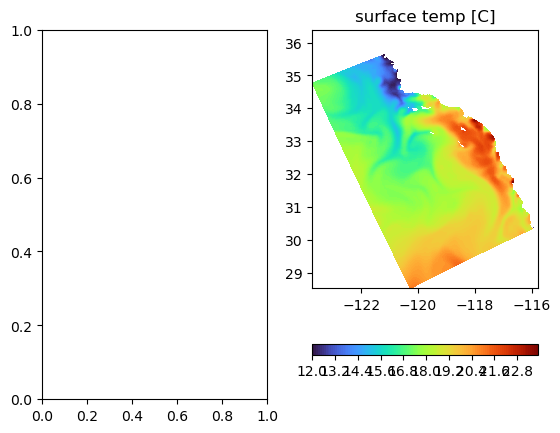

In [24]:
print(np.shape(OCN_IC['temp']))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(12,24,.1)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
#cset1=ax[0].contourf(OCN_IC['lon_rho'],OCN_IC['lat_rho'],np.squeeze(OCN_IC['temp'][0,0,:,:]),plevs)
#cbar=fig.colorbar(cset1,ax=ax[0],orientation='horizontal')
#ax[0].set_title('bottom temp [C]')

cset1=ax[1].contourf(OCN_IC['lon_rho'],OCN_IC['lat_rho'],np.squeeze(OCN_IC['temp'][0,-1,:,:]),plevs)
cbar=fig.colorbar(cset1,ax=ax[1],orientation='horizontal')
ax[1].set_title('surface temp [C]')


Text(0.5, 1.0, 'temp [C]')

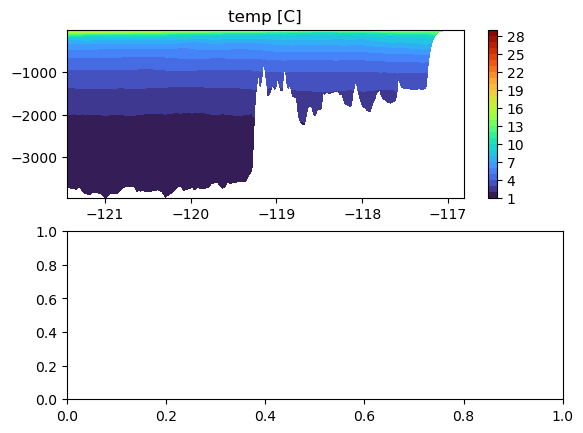

In [23]:
from scipy.interpolate import interp1d
import util_functions as utlfuns 
from util_functions import s_coordinate_4
from scipy.interpolate import RegularGridInterpolator

ilat = 130
ilon = 155
hrm = RMG['h'][ilat,ilon]

hraw = None
h = RMG['h']
eta = 0 * h
zrom = s_coordinate_4(h, 3.0 , 8.0 , 50.0 , 40, hraw=hraw, zeta=eta)
zr = np.squeeze(zrom.z_r[0,:,:,:])


zz = np.squeeze(zr[:,ilat,:])
ln = np.squeeze(OCN_IC['lon_rho'][ilat,:])
ln2 = np.ones(np.shape(zz)) * ln[None,:]

fig, ax = plt.subplots(nrows=2, ncols=1)
plevs=np.arange(1,30,1)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=ax[0].contourf(ln2,zz,OCN_IC['temp'][0,:,ilat,:],plevs)
cbar=fig.colorbar(cset1,ax=ax[0],orientation='vertical')
ax[0].set_title('temp [C]')



In [7]:
## plot OCN_R
plot_ocn_icnc= 1
if plot_ocn_icnc == 1:
    pltfuns.plot_ocn_ic_fields(ic_file_out,RMG,PFM)




In [25]:
print('using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')
# %%
# get the OCN_IC dictionary

fr_ocnR_pkl_file=1
if fr_ocnR_pkl_file==0:
    OCN_BC = ocnfuns.ocn_r_2_BCdict(OCN_R,RMG,PFM)
else:
    print('going to save OCN_BC to a pickle file to:')
    ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']
    print(ocnBC_pckl) 
    os.chdir('../sdpm_py_util')
    cmd_list = ['python','ocn_functions.py','ocn_r_2_BCdict_pckl',ocnBC_pckl]
    ret4 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('OCN BC data saved with pickle, correctly?')
    print(ret4)
    print('0=yes,1=no')
    




using:
3227656
kilobytes
going to save OCN_BC to a pickle file to:
/scratch/PFM_Simulations/LV1_Forecast/Forc/ocnBC_tmp_pckl_file.pkl


/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


get_PFM_info(): running onswell
get_PFM_info(): running onswell
got here 1
got here 1a
got here 1b
got here 1c
got here 2
got here 3
OCN_BC dict saved with pickle
OCN BC data saved with pickle, correctly?
CompletedProcess(args=['python', 'ocn_functions.py', 'ocn_r_2_BCdict_pckl', '/scratch/PFM_Simulations/LV1_Forecast/Forc/ocnBC_tmp_pckl_file.pkl'], returncode=0)
0=yes,1=no


In [26]:
print('using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')

bc_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_bc_file']
ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']

frm_BCpkl_file = 1
if frm_BCpkl_file == 0:
    print('making BC file: '+ bc_file_out)
    ocnfuns.ocn_roms_BC_dict_to_netcdf(OCN_BC, bc_file_out)
    print('done makeing BC nc file.')
else:
    print('making BC nc file from pickled BC: '+ bc_file_out)
    cmd_list = ['python','ocn_functions.py','ocn_roms_BC_dict_to_netcdf_pckl',ocnBC_pckl,bc_file_out]
    os.chdir('../sdpm_py_util')
    ret5 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('OCN BC nc data saved, correctly?')
    print(ret5)
    print('0=yes,1=no')
    print('done makeing IC .nc file.')

print('using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')


frm_ICpkl_file = 1
# get the OCN_BC dictionary

print('driver_run_forecast_LV1: done with ocn_r_2_BCdict')


using:
3227656
kilobytes
making BC nc file from pickled BC: /scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_BC.nc


/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


OCN_BC dict loaded with pickle
<xarray.Dataset>
Dimensions:      (time: 21, s_rho: 40, xr: 253, xu: 252, xv: 253, er: 390,
                  eu: 390, ev: 389)
Coordinates:
    ocean_time   (time) float64 9.348e+03 9.348e+03 ... 9.35e+03 9.35e+03
    Cs_r         (s_rho) float64 -0.9827 -0.9383 ... -9.61e-05 -1.061e-05
Dimensions without coordinates: time, s_rho, xr, xu, xv, er, eu, ev
Data variables: (12/27)
    temp_south   (time, s_rho, xr) float64 1.104 1.104 1.106 ... nan nan nan
    salt_south   (time, s_rho, xr) float64 34.71 34.71 34.71 ... nan nan nan
    u_south      (time, s_rho, xu) float64 6.761e-05 3.053e-05 ... nan nan
    v_south      (time, s_rho, xv) float64 0.001207 0.001536 ... nan nan
    ubar_south   (time, xu) float64 0.006498 0.005932 0.005461 ... nan nan nan
    vbar_south   (time, xv) float64 0.01241 0.01176 0.01121 ... nan nan nan
    ...           ...
    Vtransform   int64 2
    Vstretching  int64 4
    theta_s      float64 8.0
    theta_b      float64 3.0
 

In [27]:
# make a switch to see if this file exists. If it exists, we don't need to run the code in this block
# first the atm data
# get the data as a dict
# need to specify hhmm because nam forecast are produced at 6 hr increments
ATM = atmfuns.get_atm_data_as_dict(yyyymmdd,hhmm,run_type,atm_mod,'open_dap_nc',PFM)
# put in a function to check to make sure that all the data is good
# put in a function to plot the raw atm data if we want to


# plot some stuff
pltfuns.plot_atm_fields(ATM, RMG, PFM)
print('done with plotting ATM fields')


getting atm forecast for:
[datetime.datetime(2024, 8, 4, 12, 0) datetime.datetime(2024, 8, 4, 15, 0)
 datetime.datetime(2024, 8, 4, 18, 0) datetime.datetime(2024, 8, 4, 21, 0)
 datetime.datetime(2024, 8, 5, 0, 0) datetime.datetime(2024, 8, 5, 3, 0)
 datetime.datetime(2024, 8, 5, 6, 0) datetime.datetime(2024, 8, 5, 9, 0)
 datetime.datetime(2024, 8, 5, 12, 0) datetime.datetime(2024, 8, 5, 15, 0)
 datetime.datetime(2024, 8, 5, 18, 0) datetime.datetime(2024, 8, 5, 21, 0)
 datetime.datetime(2024, 8, 6, 0, 0) datetime.datetime(2024, 8, 6, 3, 0)
 datetime.datetime(2024, 8, 6, 6, 0) datetime.datetime(2024, 8, 6, 9, 0)
 datetime.datetime(2024, 8, 6, 12, 0) datetime.datetime(2024, 8, 6, 15, 0)
 datetime.datetime(2024, 8, 6, 18, 0) datetime.datetime(2024, 8, 6, 21, 0)
 datetime.datetime(2024, 8, 7, 0, 0)]


/home/mspydell/models/PFM_root/PFM/driver/../sdpm_py_util/plotting_functions.py:90: RuntimeWarning: overflow encountered in square
  magnitude = np.sqrt(U**2 + V**2)


done with plotting ATM fields


In [7]:
#print(ATM['Tair'])
print(ATM['Tair'][0,0,:])
print(ATM['Tair'][0,:,0])
idx = np.where(ATM['Tair'] > 500)
print(idx)
#print(np.shape(ATM['Tair']))
#print(np.shape(ATM['lon']))


[9.9990003e+20 2.0962463e+01 2.0967438e+01 2.0981171e+01 2.0987366e+01
 2.0998138e+01 2.1007996e+01 2.1015747e+01 2.1023468e+01 2.1031494e+01
 2.1038849e+01 2.1043335e+01 2.1046631e+01 2.1063568e+01 2.1081970e+01
 2.1114960e+01 2.1163361e+01 2.1181152e+01 2.1223511e+01 2.1224609e+01
 2.1217194e+01 2.1203522e+01 2.1186768e+01 2.1169983e+01 2.1153198e+01
 2.1136414e+01 2.1116760e+01 2.1092773e+01 2.1075562e+01 2.1053345e+01
 2.1032501e+01 2.1042694e+01 2.1024750e+01 2.1005066e+01 2.0992767e+01
 2.0981750e+01 2.0984070e+01 2.0992340e+01 2.0986389e+01 2.0963806e+01
 2.0939880e+01 2.0917236e+01 2.0896301e+01 2.0872955e+01 2.0849884e+01
 2.0858032e+01 2.0834045e+01 2.0808411e+01 2.0796539e+01 2.0778595e+01
 2.0763489e+01 2.0749268e+01 2.0741364e+01 2.0736938e+01 2.0731232e+01
 2.0732941e+01 2.0738342e+01 2.0741638e+01 2.0737793e+01 2.0729553e+01
 2.0729614e+01 2.0716278e+01 2.0693634e+01 2.0676849e+01 2.0666229e+01
 2.0655121e+01 2.0645477e+01 2.0629974e+01 2.0613403e+01 2.0599335e+01
 2.058

In [28]:
# put the atm data on the roms grid, and rotate the velocities
# everything in this dict turn into the atm.nc file

ATM_R  = atmfuns.get_atm_data_on_roms_grid(ATM,RMG)
print('done with: atmfuns.get_atm_data_on_roms_grid(ATM,RMG)')
# all the fields plotted with the data on roms grid


pltfuns.plot_all_fields_in_one(ATM, ATM_R, RMG, PFM)
print('done with: pltfuns.plot_all_fields_in_one(ATM, ATM_R, RMG, PFM)')


done with: atmfuns.get_atm_data_on_roms_grid(ATM,RMG)


/home/mspydell/models/PFM_root/PFM/driver/../sdpm_py_util/plotting_functions.py:328: RuntimeWarning: overflow encountered in square
  magnitude = np.sqrt(U**2 + V**2)


done with: pltfuns.plot_all_fields_in_one(ATM, ATM_R, RMG, PFM)


<Figure size 640x480 with 0 Axes>

In [29]:
# output a netcdf file of ATM_R
# make the atm .nc file here.
# fn_out is the name of the atm.nc file used by roms
fn_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_atm_file'] # LV1 atm forcing filename
print('driver_run_forcast_LV1: saving ATM file to ' + fn_out)
atmfuns.atm_roms_dict_to_netcdf(ATM_R,fn_out)
print('driver_run_forecast_LV1:  done with writing ATM file, Current time ', datetime.now())
# put in a function to plot the atm.nc file if we want to
pltfuns.load_and_plot_atm(RMG, PFM)
print('done with pltfuns.load_and_plot_atm(PFM)')



driver_run_forcast_LV1: saving ATM file to /scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_ATM_FORCING.nc
<xarray.Dataset>
Dimensions:     (tair_time: 21, er: 390, xr: 253, pair_time: 21, qair_time: 21,
                 wind_time: 21, rain_time: 21, srf_time: 21, lrf_time: 21,
                 time: 21)
Coordinates:
    lat         (er, xr) float64 28.52 28.53 28.54 28.55 ... 36.38 36.39 36.39
    lon         (er, xr) float64 -120.3 -120.2 -120.2 ... -118.8 -118.8 -118.8
    ocean_time  (time) float64 9.348e+03 9.348e+03 ... 9.35e+03 9.35e+03
  * tair_time   (tair_time) float64 9.348e+03 9.348e+03 ... 9.35e+03 9.35e+03
  * pair_time   (pair_time) float64 9.348e+03 9.348e+03 ... 9.35e+03 9.35e+03
  * qair_time   (qair_time) float64 9.348e+03 9.348e+03 ... 9.35e+03 9.35e+03
  * wind_time   (wind_time) float64 9.348e+03 9.348e+03 ... 9.35e+03 9.35e+03
  * rain_time   (rain_time) float64 9.348e+03 9.348e+03 ... 9.35e+03 9.35e+03
  * srf_time    (srf_time) float64 9.348e+03 9.348e+03 ... 9.3

In [ ]:

print('driver_run_forecast_LV1:  now make .in and .sb files')

pfm_driver_src_dir = os.getcwd()
os.chdir('../sdpm_py_util')
make_LV1_dotin_and_SLURM( PFM )

# run command will be
run_slurm_LV1(PFM)

os.chdir(pfm_driver_src_dir)


# postprocess figure generation
# plot fields from his.nc



In [2]:
# ========================================
# OLD and testing stuff is below this line
# ========================================

# note, this function is hard wired to return 2.5 days of data
# also note that the first time of this data is yyyymmdd 12:00Z
# so we grab nam atm forecast data starting at this hour too.
OCN = ocnfuns.get_ocn_data_as_dict(yyyymmdd,run_type,ocn_mod,'ncks',PFM)
print('driver_run_forecast_LV1: done with get_ocn_data_as_dict: Current time ',datetime.now() )
# add OCN plotting function here !!!!



Time to get full file using ncks = 1517.43 sec
Return code = 0 (0=success, 1=skipped ncks)
driver_run_forecast_LV1: done with get_ocn_data_as_dict: Current time  2024-07-31 13:19:42.922055


In [6]:
import xarray as xr

fn='/scratch/PFM_Simulations/LV1_Forecast/Forc/hy_cat_2024-07-29T12:00.nc'
ds = xr.open_dataset(fn)
print(ds.lat.values)


[28.         28.04000092 28.07999992 28.12000084 28.15999985 28.20000076
 28.23999977 28.28000069 28.31999969 28.36000061 28.39999962 28.44000053
 28.47999954 28.52000046 28.55999947 28.60000038 28.63999939 28.68000031
 28.71999931 28.76000023 28.79999924 28.84000015 28.87999916 28.92000008
 28.95999908 29.         29.04000092 29.07999992 29.12000084 29.15999985
 29.20000076 29.23999977 29.28000069 29.31999969 29.36000061 29.39999962
 29.44000053 29.47999954 29.52000046 29.55999947 29.60000038 29.63999939
 29.68000031 29.71999931 29.76000023 29.79999924 29.84000015 29.87999916
 29.92000008 29.95999908 30.         30.04000092 30.07999992 30.12000084
 30.15999985 30.20000076 30.23999977 30.28000069 30.31999969 30.36000061
 30.39999962 30.44000053 30.47999954 30.52000046 30.55999947 30.60000038
 30.63999939 30.68000031 30.71999931 30.76000023 30.79999924 30.84000015
 30.87999916 30.92000008 30.95999908 31.         31.04000092 31.07999992
 31.12000084 31.15999985 31.20000076 31.23999977 31

In [9]:
import os
import glob
tstr = "2024-07-30T12:00"
ffname = "hy_" + tstr + "_*.nc"
full_fns_out = PFM['lv1_forc_dir'] + "/" + ffname
ncfiles = glob.glob(full_fns_out)
cat_fname = PFM['lv1_forc_dir'] + '/' + 'hy_cat_' + tstr + '.nc'

print(ncfiles)


[]


In [29]:
from datetime import timedelta

tstr = '2024-07-30T12:00'
print(tstr)
t1 = datetime.strptime(tstr,"%Y-%m-%dT%H:%M")
t2 = t1 + 2.5 * timedelta(days=1)
print(t1)
print(t2)
t2str = t2.strftime("%Y-%m-%dT%H:%M")
print(t2str)

2024-07-30T12:00
2024-07-30 12:00:00
2024-08-02 00:00:00
2024-08-02T00:00


In [ ]:
# a block of code to use ncks...
import time
import subprocess

vstr = 'surf_el,water_temp,salinity,water_u,water_v,depth'

# make the ocn IC and BC .nc files here
# fn*_out are the names of the the IC.nc and BC.nc roms files
lv1_forc_dir = PFM['lv1_forc_dir']   #'/Users/mspydell/research/FF2024/models/SDPM_mss/atm_stuff/ocn_test_IC_file.nc'
full_fn_out = lv1_forc_dir + '/hycom_test_mss.nc'

west =  PFM['latlonbox'][2]+360.0
east =  PFM['latlonbox'][3]+360.0
south = PFM['latlonbox'][0]
north = PFM['latlonbox'][1]

yyyy = yyyymmdd[0:4]
mm = yyyymmdd[4:6]
dd = yyyymmdd[6:8]

# time limits
dstr0 = yyyy + '-' + mm + '-' + dd + 'T12:00'
dstr1 = yyyy + '-' + mm + '-' + str( int(dd) + 1 ) + 'T00:00'

url='https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0/FMRC/runs/' 
url2 = 'GLBy0.08_930_FMRC_RUN_' + yyyy + '-' + mm + '-' + dd + 'T12:00:00Z' 
url3 = url + url2
cmd_list = ['ncks',
    '-d', 'time,'+dstr0+','+dstr1,
    '-d', 'lon,'+str(west)+','+str(east),
    '-d', 'lat,'+str(south)+','+str(north),
    '-v', vstr,
    url3 ,
    '-4', '-O', full_fn_out]

print(cmd_list)

# run ncks
tt0 = time.time()
ret1 = subprocess.call(cmd_list)


In [51]:
import xarray as xr
from datetime import timedelta

ds = xr.open_dataset(full_fn_out)
#print(ds)

t_hy = ds.time
t_ref = PFM['modtime0']

dt_day = (t_hy - np.datetime64(t_ref))  / np.timedelta64(1,'D')

print(dt_day.values)
#print(t_hy[0]-t_ref)


#t_hy2 = datetime(t_hy)

#t_ref?
#deltat = t_hy - t_ref

#print(deltat)


#print(t_hy)
#print(t_ref)
      


[9340.5   9340.625 9340.75  9340.875 9341.   ]


In [5]:
zz=np.random.randn(2,3,4,5)
dum = zz[1,2,:,:]
ang = np.random.randn(4,5)
ang2 = np.tile(ang,(2,3,1,1))


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [1]:
import subprocess
import os

print(os.getcwd())
os.chdir('../sdpm_py_util')
cmd_list = ['python','ocn_functions.py','sum_fn','5','100']
ret1 = subprocess.Popen(cmd_list)

cmd_list2 = ['python','ocn_functions.py','sum_fn','5','100']
ret2 = subprocess.Popen(cmd_list2)

# placeing this here waits for the return code. i.e. the code is blocked here
# if this is commented out. Then we can reach 
#ssd1 = ret1.communicate()[0]
#rc1 = ret1.returncode
#print(rc1)

#d2 = ret2.communicate()[0]
#rc2 = ret2.returncode
#print(rc2)

print('make it through and subprocesses are still spinning')

os.chdir('../driver')
print(os.getcwd())


/home/mspydell/models/PFM_root/PFM/driver
make it through and subprocesses are still spinning
/home/mspydell/models/PFM_root/PFM/driver


/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:23: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater
/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:23: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


in loop:
0
-13
in loop:
1
31
in loop:
0
-15
in loop:
2
4
in loop:
1
10
in loop:
3
-20
in loop:
2
21
in loop:
4
28
in loop:
3
-9
in loop:
0
6
in loop:
4
-16
in loop:
1
-12
in loop:
0
-5
in loop:
2
-19
in loop:
1
-6
in loop:
3
21
in loop:
2
32
in loop:
4
-9
in loop:
3
60
in loop:
4
-15


In [4]:
ssd1 = ret1.communicate()[0]
rc1a = ret1.returncode
print('return code 1 is now:')
print(rc1a)
ssd2 = ret2.communicate()[0]
rc2a = ret2.returncode
print('return code 2 is now:')
print(rc2a)

return code 1 is now:
0
return code 2 is now:
0
